<h2>Visualização Computacional<h2>

In [ ]:
import gdown
file_id = '1WB02QmaYoV_ZJ32aOveyyIqc5zMqwdJ-'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'dados_formatados_por_dia.xlsx', quiet=False)
path = 'dados_formatados_por_dia.xlsx'

Downloading...
From: https://drive.google.com/uc?id=1WB02QmaYoV_ZJ32aOveyyIqc5zMqwdJ-
To: /content/dados_formatados_por_dia.xlsx
100%|██████████| 27.5k/27.5k [00:00<00:00, 15.0MB/s]


In [ ]:
import pandas as pd
import plotly.express as px

# Caminho do arquivo
arquivo = "dados_formatados_por_dia.xlsx"

# Escolha o dia desejado
dia_escolhido = "Segunda-feira"  # altere para outro dia

# Lê a aba correspondente
df = pd.read_excel(arquivo, sheet_name=dia_escolhido)

# Normaliza o formato da hora
df["hora"] = pd.to_datetime(df["hora"], format="%H:%M:%S").dt.strftime("%H:%M:%S")

# Cria todas as 24 horas
todas_horas = [f"{h:02d}:00:00" for h in range(24)]

# Preenche horas faltantes
locais_unicos = df[["instituto", "local", "lat", "lon"]].drop_duplicates()
df_completo = []
for _, local in locais_unicos.iterrows():
    base = pd.DataFrame({
        "instituto": local["instituto"],
        "local": local["local"],
        "lat": local["lat"],
        "lon": local["lon"],
        "hora": todas_horas
    })
    merged = base.merge(df, on=["instituto", "local", "lat", "lon", "hora"], how="left")
    df_completo.append(merged)

df_completo = pd.concat(df_completo, ignore_index=True)
df_completo["valor"] = df_completo["valor"].fillna(0)
df_completo = df_completo.sort_values("hora")

# Cria o mapa com cores por instituto
fig = px.scatter_mapbox(
    df_completo,
    lat="lat",
    lon="lon",
    color="instituto",        # cores distintas por instituto
    size="valor",             # tamanho dos pontos conforme o valor
    hover_name="local",
    hover_data=["instituto", "hora", "valor"],
    animation_frame="hora",
    zoom=14,
    height=700,
    title=f"Mapa Temporal dos Institutos da USP São Carlos - {dia_escolhido}",
)

# Fundo preto e branco, sem ícones
fig.update_layout(
    mapbox_style="carto-positron",  # mapa P&B minimalista
    margin={"r":0,"t":40,"l":0,"b":0},
)

fig.show()


# Respondendo à questão "Quais são os principais temas de cada curso?"

## Pré-Processamento da ementa e do conteúdo programático

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
database= "DB.csv"

df = pd.read_csv(database)

df = df.dropna(subset=['ementa', 'conteudo_programatico'])

In [ ]:
def clean_text(text: str) -> str:
    # Replace newlines and tabs with spaces
    text = text.replace('\n', ' ').replace('\t', ' ')

    # Remove list markers like a), b), c), etc.

    text = re.sub(r'\b[a-e]\)', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove stray commas before periods
    text = re.sub(r',\s*\.', '.', text)

    # Strip leading/trailing spaces and capitalize first letter
    text = text.strip()

    return text

In [ ]:
texts = df['ementa'].apply(clean_text) + ' ' + df['conteudo_programatico'].apply(clean_text)

## Extração de palavras-chave

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 114.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

def filter_nouns_adj(text):
  """
  Usa spaCy para extrair apenas tokens úteis (substantivos, adjetivos e nomes próprios)
  e remover stopwords e termos genéricos.
  """
  nlp = spacy.load("pt_core_news_sm")
  doc = nlp(text)
  tokens = [
      token.lemma_.lower()
      for token in doc
      if token.pos_ in {"NOUN", "PROPN", "ADJ"}      # classes gramaticais úteis
      and not token.is_stop                          # remove stopwords do spaCy
      and token.lemma_.lower()   # remove termos genéricos e stopwords NLTK
      and len(token.text) > 2                        # evita palavras curtas
  ]
  print(tokens)
  return " ".join(tokens)

In [ ]:
from collections import Counter
import itertools

def build_domain_stopwords(texts, top_k=50):
    """
    Gera stopwords específicas do domínio com base em todas as ementas.
    texts deve ser uma lista de listas de palavras. A partir daqui,
    um filtro manual deve ser feito para remover palavras indesejadas.
    """
    # "Achata" a lista de listas → ['química', 'dados', 'energia', ...]
    all_tokens = list(itertools.chain.from_iterable(texts))

    # Conta a frequência
    freq = Counter(all_tokens)

    # Pega as mais comuns
    most_common = [w for w, _ in freq.most_common(top_k)]

    print(f"🔹 {len(most_common)} stopwords de domínio adicionadas.")
    return most_common


In [ ]:
def select_keywords(text, vectorizer, top_n=15):
    """
    Retorna as top-N palavras-chave de um texto usando TF-IDF.
    Retorna lista vazia se o vocabulário ficar vazio após remoção de stopwords.
    """
    try:
        # Aplica TF-IDF
        X = vectorizer.fit_transform([text])
        tfidf_scores = X.toarray()[0]
        terms = vectorizer.get_feature_names_out()
        # Ordena pelas palavras com maior peso
        indices = np.argsort(tfidf_scores)[::-1][:top_n]
        keywords = [terms[i] for i in indices]
        return keywords
    except ValueError as e:
        if "empty vocabulary" in str(e):
            return []  # retorna lista vazia se todas as palavras foram removidas
        else:
            raise  # se for outro erro, propaga


In [ ]:
#texts = texts.apply(filter_nouns_adj)

In [ ]:
keywords = []
for text in texts.to_list():
  keywords.append(text.split())

In [ ]:
stopwords = build_domain_stopwords(keywords)

🔹 50 stopwords de domínio adicionadas.


In [ ]:
print(stopwords)

['de', 'e', 'da', 'do', 'em', 'a', 'para', 'dos', '-', 'com', 'o', 'A', 'das', 'no', 'sistemas', 'O', 'na', 'um', 'por', 'Introdução', 'à', 'uma', 'Sistemas', 'os', 'sobre', 'projeto', 'análise', '2.', 'ser', 'que', 'ao', 'as', '1.', 'como', '3.', 'ou', '4.', 'entre', 'Análise', '5.', 'semanas)', 'conceitos', 'dados', 'técnicas', 'disciplina', 'Métodos', '6.', 'desenvolvimento', 'Lei', 'equações']


In [ ]:
#Analisando manualmente a lista

#lista de 50 palavras mais frequente em todas as ementas
  #'projeto', 'sistema', 'aplicação', 'método', 'análise', 'introdução',
  #'conceito', 'processo', 'dado', 'modelo', 'estrutura', 'semana', 'disciplina',
  #'básico', 'energia', 'problema', 'equação', 'controle', 'sistemas', 'planejamento',
  #'atividade', 'propriedade', 'estudo', 'desenvolvimento', 'função', 'lei',
  #'material', 'linear', 'trabalho', 'teoria', 'princípio', 'movimento', 'engenharia',
  #'ambiental', 'definição', 'representação', 'curso', 'programa', 'técnica', 'aluno',
  #'arquitetura', 'programação', 'pesquisa', 'produção', 'solução', 'circuito',
  #'elétrico', 'espaço', 'gestão', 'linguagem'

#palavras que, na verdade, são relevantes:
  #energia, equação, controle, função, lei, material, linear, movimento,
  #engenharia, ambiental, arquitetura, programação, pesquisa, produção, circuito,
  #elétrico, espaço, gestão, linguagem

#outras palavras que devem ser ignoradas:
  #tema, didático, introdução, visão geral, visão


#lista final de palavras que devem ser ignoradas:
manual_stopwords = [
    'projeto', 'sistema', 'aplicação', 'método', 'análise', 'introdução',
    'conceito', 'processo', 'dado', 'modelo', 'estrutura', 'semana',
    'disciplina', 'básico', 'problema', 'sistemas', 'planejamento',
    'atividade', 'propriedade', 'estudo', 'desenvolvimento', 'trabalho', 'teoria',
    'princípio', 'definição', 'representação', 'curso', 'programa',
    'técnica', 'aluno', 'solução', 'tema', 'didático', 'introdução',
    'visão geral', 'visão'
]




In [ ]:
#extração de keywords
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords', quiet=True)
stopwords_pt = stopwords.words('portuguese')

all_stopwords = list(set(stopwords_pt + manual_stopwords))

# 4. Inicializa o vetorizador TF-IDF com as stopwords e n-grams
vectorizer = TfidfVectorizer(stop_words=all_stopwords,ngram_range=(1, 2))


In [ ]:
keywords = texts.apply(lambda t: select_keywords(t, vectorizer=vectorizer, top_n=15))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['geral'] not in stop_words.



In [ ]:
keywords

,0
0,"[química, discussão, temas, universitária, pro..."
1,"[química, sobre, pesquisa, ciência, atividades..."
2,"[química, acadêmico, ênfases, mercado, carreir..."
3,"[química, acadêmico, ênfases, mercado, carreir..."
4,"[spin, rmn, massas, espectros, carbono, nuclea..."
...,...
1901,"[resposta, liberdade, resposta livre, livre, v..."
1902,"[imagens, classificadores, características, mé..."
1903,"[imagens, visual, câmera, modelos câmera, mode..."
1904,"[produção, processos, engenharia, gestão, qual..."


In [ ]:
df['keywords'] = keywords

In [ ]:
df.to_csv('DB_keywords.csv')

## Plots

In [ ]:
import ast

def get_keywords(df, curso='', periodos=[]):
  '''
  Retorna todas as keywords, sem repetição de determinados
  períodos de um curso. Caso nenhum período seja especificado,
  retorna todas as keywords de todos os períodos daquele curso.
  '''

  df_curso = df[df['curso'] == curso]
  if periodos:
    df_curso = df_curso[df_curso['periodo'].isin(periodos)]


  keywords = df_curso['keywords'].apply(ast.literal_eval)  # converte string -> lista
  keywords = [word for row in keywords for word in row]    # agora sim, lista plana
  keywords = [w.strip().lower() for w in keywords]

  return keywords

In [ ]:
df = pd.read_csv('DB_keywords.csv')

In [ ]:
import re

numbers = [
    int(re.findall(r'\d+', str(text))[0])
    if re.findall(r'\d+', str(text)) else None
    for text in df['periodo']
]

df['periodo'] = numbers

In [ ]:
df.head()

,Unnamed: 0,instituto,curso,periodo,codigo,codigo.1,nome,ementa,conteudo_programatico,departamento,keywords
0,0,Instituto de Química de São Carlos,Química,1.0,7500002,7500002,Acompanhamento Profissional e Pessoal I,Acompanhamento do progresso acadêmico dos alun...,"Reuniões semanais,\nEnvolvendo os temas:\na)\t...",Disciplinas Interdepartamentais do IQSC,"['química', 'discussão', 'temas', 'universitár..."
1,1,Instituto de Química de São Carlos,Química,2.0,7500019,7500019,Acompanhamento Profissional e Pessoal II,Acompanhamento do progresso acadêmico dos alun...,A Química como Ciência e Profissão: A Ciência ...,Disciplinas Interdepartamentais do IQSC,"['química', 'sobre', 'pesquisa', 'ciência', 'a..."
2,2,Instituto de Química de São Carlos,NaN,NaN,7500020,NaN,Acompanhamento Profissional e Pessoal III,Desenvolver atividades de estudos e discussões...,Desenvolver atividades de estudos e discussões...,NaN,"['química', 'acadêmico', 'ênfases', 'mercado',..."
3,3,Instituto de Química de São Carlos,NaN,NaN,7500021,NaN,Acompanhamento Profissional e Pessoal IV,Desenvolver atividades de estudos e discussões...,Desenvolver atividades de estudos e discussões...,NaN,"['química', 'acadêmico', 'ênfases', 'mercado',..."
4,4,Instituto de Química de São Carlos,Química,4.0,7500036,7500036,Análise de Compostos Orgânicos,Espectroscopia no Ultravioleta. Espectroscopia...,Índice de deficiência de hidrogênio. Bases fís...,Disciplinas Interdepartamentais do IQSC,"['spin', 'rmn', 'massas', 'espectros', 'carbon..."


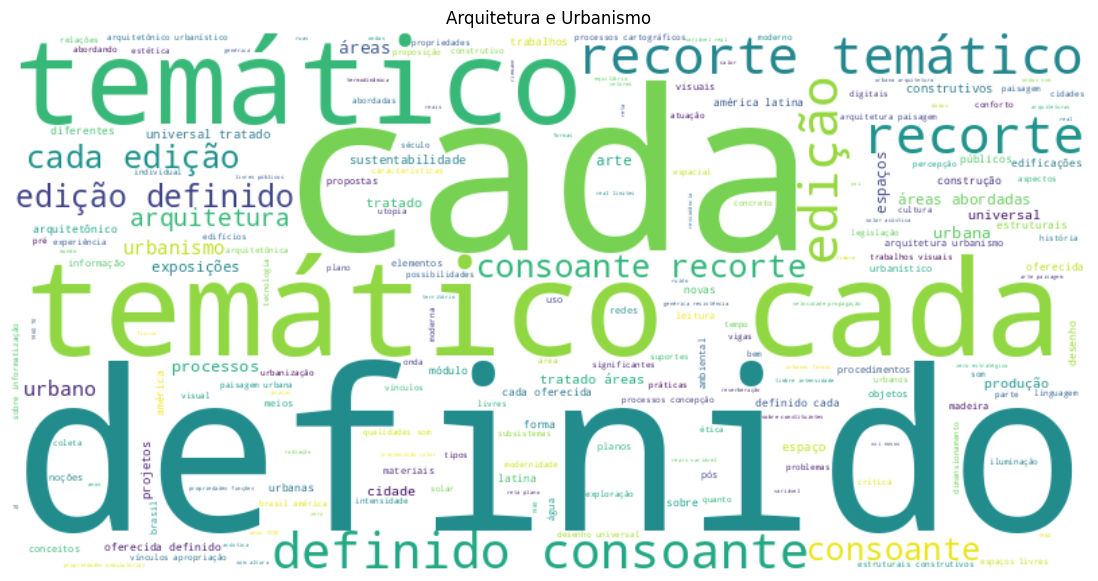

In [ ]:
curso = 'Arquitetura e Urbanismo'
periodos = []

all_keywords = get_keywords(df, curso='Arquitetura e Urbanismo', periodos=[])


freq = Counter(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)

# Plota
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Arquitetura e Urbanismo")
plt.show()


In [ ]:
df.curso.unique()

array(['Química', nan, 'Engenharia Ambiental', 'Engenharia de Produção',
       'Bacharelado em Física Biomolecular',
       'Bacharelado em Física Computacional', 'Física',
       'Engenharia Aeronáutica', 'Engenharia Civil',
       'Engenharia de Materiais e Manufatura', 'Engenharia Elétrica',
       'Engenharia Mecânica', 'Engenharia Mecatrônica',
       'Engenharia de Computação', 'Arquitetura e Urbanismo',
       'Bacharelado em Ciências de Computação', 'Matemática',
       'Bacharelado em Matemática Aplicada e Computação Científica',
       'Bacharelado em Sistemas de Informação',
       'Bacharelado em Ciência de Dados',
       'Bacharelado em Estatística e Ciência de Dados'], dtype=object)

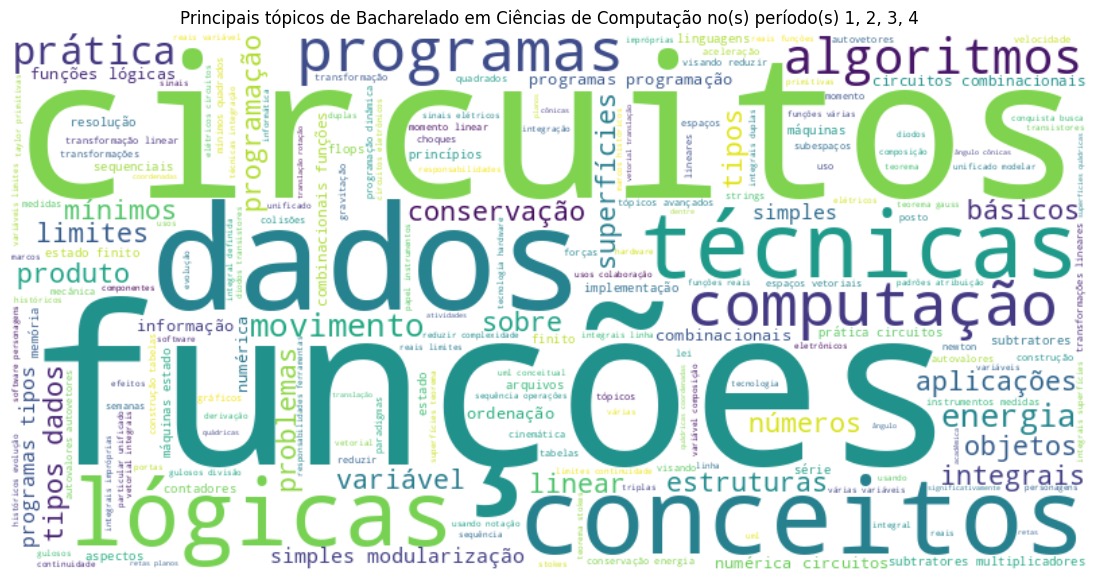

In [ ]:
curso = 'Bacharelado em Ciências de Computação'
periodos = [1,2,3,4]

all_keywords = get_keywords(df, curso=curso, periodos=periodos)

freq = Counter(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)

# Plota
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Principais tópicos de {curso} no(s) período(s) {', '.join(str(int(p)) for p in periodos)}")
plt.show()


# Outra questão

<h2>Criação da Base dos Locais:<h2>

In [ ]:
# @title
import requests
import time

# Cria sessão e define cabeçalhos
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/128.0.0.0 Safari/537.36"
}

# Lista de disciplinas
disciplinas = [
"1800040","SCC0280","SCC0580","SHS0371","SHS0372","SEP0358","SEP0359","SEP0529","SAA0199","SAA0354","SAA0355","SEM0578","SAA0109","SAA0110","SAA0159","SAA0115",
"STT0403","SCC0218","SCC0202","SCC0502","SCC0602","SCC0203","SCC0503","SCC0603","SET0606","SEP0532","SEP0533","SHS0380","STT0622","SEL0436","SEL0331","SET0610",
"SMM0567","SMM0568","1800119","SEL0344","SEL0433","SEL0614","SEL0336","SEL0356","SCC0233","SCC0634","SEL0629","STT0626","SCC0276","SEM0592","SHS0115","SCC0243",
"SCC0295","SCC0296","1800105","SMM0218","SMM0219","1800100","1800101","1800102","1800103","1800104","1800108","1800111","1800112","1800113","1800114","SEL0406",
"SEP0605","SHS0386","SEP0564","STT0623","SHS0352","SCC0247","SGS0621","SCC0540","SCC0240","SCC0640","SEL0388","SEL0429","SHS0377","SHS0378","SMM0307","SEM0589",
"SAA0357","SEL0348","SHS0373","SHS0374","SAA0352","SET0630","SET0631","SEP0348","SEP0143","SHS0614","SMM0300","SMM0348","SHS0358","SEL0439","SEL0602","SEL0301",
"SEL0302","SEL0637","SEL0609","SEL0313","SEL0314","SEL0613","SEL0315","SHS0306","SCC0277","STT0611","SET0600","SMM0174","SMM0328","SCC0250","SEL0377","SCC0650",
"SEL0387","SCC0207","SEL0619","SEL0346","SEL0347","SEL0366","SHS0333","SET0411","SGS0304","STT0609","SEP0584","SEP0561","SEL0465","SEL0367","SEL0342","SEL0633",
"SEL0326","SEM0591","SEL0359","SEL0620","SEL0458","SEL0457","SEP0354","SEL0364","SEL0382","SEL0329","SAA0348","SEL0435","SMM0334","SAA0350","SAA0349","SAA0183",
"1800123","SEM0502","SEM0564","SEM0565","SEM0503","SEM0574","SEL0456","SET0625","SEP0548","SEM0414","SEM0501","SEM0577","SEM0590","SEM0583","SAA0184","SEL0357",
"SEM0317","SEM0504","SEL0420","STT0621","SHS0385","SHS0314","SEP0586","SEP0569","SEP0570","SEP0572","SHS0369","SHS0370","SEL0437","SET0620","SET0621","SEM0241",
"SEM0326","SEM0327","SEM0396","SEL0410","SEL0403","SEL0404","SEL0608","SEL0309","SEL0411","SMM0166","SEL0401","SCC0209","SEP0531","SHS0382","SEM0593","SEM0594",
"SEM0391","SEL0375","SEM0546","SMM0318","STT0628","SEP0600","SMM0193","SMM0194","STT0612","STT0613","SMM0311","SAA0359","SEP0493","SEP0545","SEL0355","1807100",
"1800323","SAA0170","1800090","SEL0425","1800122","SEM0398","SEP0622","SEL0625","SMM0324","1800078","SCC0291","SCC0292","SEM0500","SET0415","SET0416","SEM0555",
"STT0406","STT0407","SEP0574","SEP0546","SET0618","SCC0606","SCC0607","SET0409","SET0410","SET0605","SCC0122","SCC0223","SCC0224","SET0408","SET0406","SAA0351",
"SET0632","SET0417","SET0418","SET0633","SET0608","1800322","SEM0324","SEM0560","SMM0156","SAA0360","SHS0619","SEM0551","SHS0406","SHS0407","SEM0588","SHS0356",
"SHS0357","SHS0179","STT0630","SET0613","SEP0141","SGS0404","SEM0587","SEM0403","SEL0417","SEL0611","SEP0566","SEL0466","STT0408","SEP0271","SEL0459","SEL0460",
"SEL0461","SEL0617","SEL0607","SEM0360","SGS0405","SGS0406","SGS0329","SGS0330","STT0177","STT0616","STT0614","STT0409","STT0410","SGS0306","SEL0363","SEP0171",
"SHS0623","SEP0346","SEP0140","SEP0701","SEP0356","SHS0381","SEP0174","1800106","SHS0319","SEP0327","SEP0527","SEP0255","SEP0530","1800115","SHS0409","SHS0410",
"SEM0540","SHS0361","SHS0362","SHS0359","SHS0411","SHS0412","SAA0191","SEP0501","SAA0164","SEL0434","SHS0375","SHS0376","SEP0573","SCC0200","SEL0600","SMM0216",
"SEP0177","SEL0440","SEL0453","SEL0311","SEL0312","SHS0402","SHS0613","SEM0539","SEL0345","SEL0352","SHS0383","SEL0362","SCC0530","SCC0230","SCC0630","SEM0579",
"SCC0260","SCC0560","SEM0320","SEP0588","SCC0271","SCC0120","SCC0221","SCC0201","SCC0275","SEP0144","SCC0303","SCC0370","1800314","1800118","1800107","SMM0566",
"SEP0100","SEL0395","STT0625","SEL0300","SEM0394","SEM0528","SMM0571","SMM0224","SCC0254","SGS0602","SGS0619","SEL0396","SET0188","SMM0339","SMM0570","SAA0197",
"SEL0415","SEP0629","SAA0364","SCC0121","SCC0124","SCC0570","SAA0207","SCC0231","SCC0531","SCC0631","SCC0505","SEL0462","SCC0283","SCC0219","SMM0340","SMM0342",
"SET0601","SEL0449","SMM0572","SEM0407","SMM0343","SEL0454","SEL0405","SAA0180","SET0400","SCC0210","SCC0211","SEL0430","SCC0641","SCC0241","SCC0541","SEL0610",
"SEL0418","SEL0316","SEL0317","SEL0318","SEL0431","SEL0328","SEL0330","SCC0225","SEL0306","SEL0327","SEL0393","SCC0220","SCC0222","SET0614","SEL0423","SMM0309",
"SEL0441","1800318","1800300","SEL0402","SEL0634","SAA0345","SEL0455","SEL0606","SEL0384","SEL0323","SEL0467","SEL0361","SEP0202","SAA0213","SAA0214","SEL0632",
"SCC0217","SEL0365","STT0631","SEP0305","STT0610","SEP0303","STT0619","SMM0215","SHS0388","SEM0350","SAA0114","SAA0160","SEL0422","SHS0103","SMM0319","SMM0305",
"SMM0310","SMM0574","SMM0308","SMM0575","SMM0181","SMM0182","SET0419","SET0420","SMM0301","SMM0303","SMM0304","SGS0403","SMM0157","SMM0171","SET0180","SET0181",
"SAA0215","SHS0173","SET0623","SET0186","SET0190","SET0413","SET0183","SET0191","SET0414","SET0184","SET0185","SGS0407","SGS0408","SGS0130","SEM0585","SEM0104",
"SEL0452","SMM0326","1800082","SCC0213","SGS0305","SEL0424","SEM0522","SAA0198","SEP0700","SEL0369","SHS0312","SMM0564","SCC0244","SCC0173","SCC0287","SGS0620",
"STT0182","SHS0392","SCC0216","SHS0624","SEP0324","SEP0301","SEM0533","SEM0535","SEM0397","SEP0142","SEM0232","SHS0365","SCC0261","SCC0561","SCC0661","SEM0406",
"1800043","1800117","SEL0612","SEL0310","SEL0463","SHS0346","SEL0464","SCC0215","SEM0543","SEP0502","SEP0500","SEM0572","SAA0337","SAA0338","SET0629","SEP0405",
"SEP0406","SEP0441","STT0405","SEP0325","SEP0326","SEP0328","SEP0221","SHS0390","SHS0350","SHS0351","SET0412","SET0617","SET0622","SEP0172","SCC0802","SAA0165",
"SEM0581","SHS0389","SEM0570","SEM0569","SEP0275","SEP0285","SMM0330","SEL0353","SMM0177","SAA0167","SEL0616","SEL0360","SEP0587","SEL0203","SEP0175","SEM0584",
"SEM0388","SEL0397","SEM0529","SEM0530","SEM0531","SEM0532","SEM0537","SEL0631","SCC0245","SCC0651","SCC0251","SCC0633","SEP0279","SEM0412","SMM0315","SMM0314",
"SMM0323","SMM0316","SEM0554","SEL0343","SEL0615","SMM0302","SEP0152","SEP0277","SEM0567","SEM0534","SEP0283","SEM0343","SEP0282","SCC0204","SCC0604","SCC0504",
"SAA0363","SEM0303","SAA0200","SAA0201","SCC0214","SEL0380","SAA0336","SAA0205","SET0634","SEP0139","SMM0569","SEL0624","SCC0293","SCC0294","SEP0252","SHS0336",
"SEM0563","SEM0541","SEM0542","SEP0451","SAA0189","SEP0284","SEP0254","SMM0561","SCC0289","SCC0290","SEL0373","1800315","SCC0300","SCC0302","1800083","SAA0346",
"SMM0325","1800093","SEL0442","SEM0399","1800094","SEL0444","SEM0404","SEP0628","SEP0625","1800116","SEM0347","SEM0568","SEL0618","SEL0621","SEL0622","SEP0571",
"SEL0398","SEL0438","SEL0630","SEL0337","SAA0362","SMM0573","SAA0117","SAA0353","SEL0354","SEP0280","SHS0601","SEL0409","SCC0282","SGS0303","SCC0281","SHS0348",
"SHS0360","SEL0378","SEL0432","SEL0370","SEL0386","SCC0270","SAA0358","SGS0605","SMM0306","SGS0327","SEM0586","SCC0273","SEM0573","SHS0413","SHS0414","SHS0614",
"SMM0333","SEL0450","SCC0227","SCC0228","SCC0229","SEP0135","SEP0136","SEP0145","SEM0142","SEL0385","SEL0623","SEM0372","SEL0381","SEP0404","SEL0604","SEL0383",
"SEP0357","SHS0416","SGS0328","SHS0408","SAA0187","SHS0323","SEP0506","SHS0384","SEL0371","SEM0169","SAA0168","SAA0169","SEM0536","SEM0538","SHS0349","SEP0702",
"SEP0507","SEP0504","STT0620","SCC0284","SEM0251","SHS0180","SEL0414","SEL0628","SAA0180","SEM0566","SEM0544","SAA0356","SET0196","SET0403","SET0195","SET0197",
"SET0198","SET0194","SET0192","SET0193","SEL0421","SEM0545","SEM0250","SEM0571","SMM0204","SEP0606","SEP0627","SGS0302","SMM0341","SEL0412","SET0628","SEL0413",
"SET0615","SCC0605","SCC0205","SHS0344","SMM0562","SEM0233","SEM0345","SEM0548","SCC0910","SCC0911","STT0411","STT0629","SCC0632","SHS0615","1800319","1800320",
"1800321","SEM0580","SMM0565","SAA0361","SEL0338","1800080","1800081","1800091","SEL0358","SAA0216","SHS0181","SEM0550","STT0618","STT0605","STT0604","SHS0321",
"SHS0170","1800120","1800121","SEP0631","SEP0632","SEP0633","SEP0634","SEP0635","SEP0272","SEM0576","SEM0575","SEM0172","SEL0339","SEL0635","SEP0133","SEP0134",
"SCC0252","SCC0652","IAU0952","IAU0982","IAU0727","IAU0973","IAU0728","IAU0983","IAU0411","IAU0412","IAU0953","IAU0963","IAU0933","IAU0943","IAU0676","IAU0974",
"IAU0925","IAU0955","IAU0649","IAU0675","IAU0409","IAU0410","IAU0314","IAU0315","IAU0755","IAU0678","IAU0737","IAU0738","IAU0136","IAU0135","IAU0916","IAU0926",
"IAU0144","IAU0145","IAU0313","IAU0701","IAU0990","IAU0643","IAU0954","IAU0644","IAU0964","IAU0126","IAU0743","IAU0744","IAU0650","IAU0923","IAU0648","IAU0401",
"IAU2119","IAU0651","IAU0991","IAU0913","IAU0741","IAU0976","IAU0742","IAU0986","IAU0956","IAU0966","IAU0739","IAU0936","IAU0740","IAU0946","IAU0935","IAU0407",
"IAU0408","IAU0917","IAU0927","IAU0942","IAU0745","IAU0746","IAU0693","IAU0310","IAU0965","IAU0729","IAU0918","IAU0730","IAU0928","IAU0934","IAU0911","IAU0731",
"IAU0732","IAU0921","IAU0751","IAU0752","IAU0931","IAU0733","IAU0734","IAU0941","IAU0735","IAU0736","IAU0951","IAU0961","IAU0971","IAU0981","IAU2101","IAU2104",
"IAU2107","IAU2110","IAU2113","IAU2116","IAU2102","IAU2105","IAU2108","IAU2111","IAU2114","IAU2117","IAU2103","IAU2106","IAU2109","IAU2112","IAU2115","IAU2118",
"IAU2122","IAU2125","IAU2128","IAU2131","IAU2134","IAU2137","IAU2123","IAU2126","IAU2129","IAU2132","IAU2135","IAU2138","IAU2124","IAU2127","IAU2130","IAU2133",
"IAU2136","IAU2139","IAU2201","IAU2207","IAU2221","IAU2227","IAU2241","IAU2261","IAU2202","IAU2208","IAU2222","IAU2228","IAU2242","IAU2262","IAU2203","IAU2209",
"IAU2223","IAU2229","IAU2243","IAU2263","IAU2204","IAU2210","IAU2224","IAU2230","IAU2244","IAU2264","IAU2205","IAU2211","IAU2225","IAU2231","IAU2245","IAU2265",
"IAU2206","IAU2212","IAU2226","IAU2232","IAU2246","IAU2266","IAU0945","IAU0915","IAU0975","IAU0747","IAU0748","IAU0749","IAU0750","IAU0753","IAU0754","IAU0725",
"IAU0726","IAU0992","IAU2120","IAU2121","IAU0756","IAU2005","IAU2007","IAU2001","IAU2002","IAU2016","IAU2004","IAU2006","IAU2017","IAU2008","IAU2018","IAU2010",
"IAU2011","IAU2019","IAU2013","IAU2014","IAU2020","SMA0383","SCC0280","SCC0580","SME0280","SME0281","SSC0152","SMA0305","SMA0306","SMA0173","SMA0304","SMA0375",
"SME0142","SME0141","SME0341","SMA0374","SMA0804","SCC0218","SCC0202","SCC0502","SCC0602","SCC0203","SCC0503","SCC0603","SMA0380","SMA0337","SME0811","SME0262",
"SME0821","SSC0526","SSC0124","SMA0307","SMA0308","SME0822","SMA0347","SCC0233","SCC0634","SMA0357","SME0829","SCC0276","SME0860","SMA0345","SSC0510","SSC0611",
"SCC0243","SSC0725","SSC0581","SSC0582","SSC0583","SSC0584","SMA0381","SME0893","SMA0382","SME0894","SCC0295","SCC0296","SMA0395","SMA0396","SMA0397","SMA0351",
"SMA0352","SSC0643","SCC0247","SCC0540","SCC0240","SCC0640","SME0871","SMA0801","SMA0353","SMA0501","SMA0301","SMA0392","SMA0802","SMA0332","SMA0354","SMA0390",
"SMA0355","SMA0803","SMA0333","SMA0393","SMA0356","SMA0391","SME0104","SME0300","SME0500","SME0602","SME0892","SCC0277","SMA0123","SSC0903","SSC0744","SSC0571",
"SSC0158","SCC0250","SCC0650","SME0333","SME0334","SCC0207","SSC0572","SME0882","SSC0958","SMA0142","SSC0951","SSC0961","SMA0339","SMA0377","SME0890","SME0891",
"SME0873","SMA0398","SSC0512","SMA0341","SSC0180","SCC0209","SSC0570","SME0862","SSC0900","SSC0547","SSC0527","SSC0620","SSC0130","SSC0720","SMA0328","SMA0350",
"SME0240","SME0340","SMA0169","SMA0343","SSC0676","SME0284","SMA0367","SMA0370","SMA0371","SME0814","SME0815","SSC0672","SCC0291","SSC0591","SCC0292","SSC0592",
"SSC0673","SME0123","SME0806","SME0620","SME0320","SSC0603","SCC0606","SCC0607","SMA0338","SME0827","SCC0122","SCC0223","SCC0224","SSC0104","SMA0327","SMA0326",
"SME0214","SMA0378","SME0245","SME0332","SME0206","SMA0386","5500004","SMA0334","SMA0309","SMA0800","SMA0300","SMA0394","SMA0175","SMA0369","SSC0535","SSC0128",
"SME0824","SSC0962","SSC0531","SMA0368","SMA0329","SMA0348","SSC0963","SME0809","SME0818","SCC0200","5500005","SME0850","SSC0671","SSC0599","SSC0954","SCC0530",
"SCC0230","SCC0630","SSC0967","SCC0260","SCC0560","SSC0952","SMA0120","SCC0271","SCC0120","SSC0501","SSC0600","SCC0221","SSC0800","SSC0602","SSC0503","SCC0201",
"SME0828","SCC0275","SCC0303","SCC0370","SSC0964","SSC0301","SME0520","SCC0254","SME0221","SSC0117","SMA0376","SME0256","SME0241","SME0510","SCC0121","SME0330",
"SME0230","SCC0124","SSC0304","SCC0570","SSC0955","SSC0530","SCC0231","SCC0531","SCC0631","SCC0505","SMA0143","SMA0389","SME0220","SMA0192","SMA0385","SCC0283",
"SSC0770","SCC0219","SMA0125","SMA0340","SMA0193","SMA0344","SCC0210","SCC0211","SCC0641","SCC0241","SCC0541","SCC0225","SSC0901","SCC0220","SCC0222","SSC0502",
"SSC0601","SSC0801","SMA0372","SCC0217","SMA0508","SMA0180","SME0346","SME0343","SME0344","SME0819","SMA0505","SMA0387","SME0251","SME0253","SMA0379","SME0254",
"SME0825","SME0826","SMA0365","SMA0366","SCC0213","SMA0346","SSC0532","SME0205","SSC0722","SME0810","SME0305","SME0306","SME0202","SME0301","SME0302","SME0250",
"SSC0116","SCC0244","SCC0173","SCC0287","SME0879","SME0878","SCC0216","SSC0534","SSC0160","SME0271","SSC0621","SME0823","SME0820","SME0812","SCC0261","SCC0561",
"SCC0661","SCC0215","SSC0511","SSC0610","SSC0513","SSC0902","SME0213","SME0211","SME0212","SME0861","SME0816","SMA0186","SMA0187","SME0852","SSC0957","SME0853",
"SCC0802","SSC0109","SME0273","SSC0119","SSC0108","SSC0141","SME0800","SME0830","SME0801","SCC0245","SCC0651","SCC0251","SCC0633","SME0121","SME0805","SSC0742",
"SSC0712","SSC0960","SME0610","SME0110","SCC0204","SCC0604","SSC0103","SCC0504","SCC0214","SSC0670","SSC0674","SME0880","SME0881","SCC0293","SSC0593","SCC0294",
"SSC0594","SSC0536","SSC0950","SSC0741","SSC0597","SCC0289","SSC0598","SCC0290","SSC0675","SCC0300","SSC0595","SCC0302","SSC0596","SCC0282","SCC0281","SME0130",
"SSC0540","SSC0641","SSC0142","SSC0748","SCC0270","SSC0533","SSC0726","SSC0714","SCC0273","5500003","SMA0384","SSC0154","SCC0227","SSC0576","SCC0228","SSC0577",
"SSC0578","SCC0229","5500002","SSC0715","SME0808","SME0255","SSC0528","SSC0723","SSC0745","SSC0904","SSC0642","SSC0746","SSC0622","SSC0120","SCC0284","SSC0118",
"SSC0724","SSC0740","SME0252","SSC0713","SSC0953","SSC0140","SSC0541","SSC0640","SSC0743","SSC0956","SSC0965","SME0807","SCC0605","SCC0205","SME0876","SME0243",
"SMA0136","SSC0959","SSC0721","SCC0910","SCC0911","SSC0159","SCC0632","SMA0805","SMA0178","SMA0361","SMA0362","SMA0363","SMA0364","SME0216","SME0274","SSC0123",
"SSC0523","SME0870","SME0875","SSC0147","SMA0171","SMA0388","SME0285","SSC0524","SCC0252","SCC0652","SME0803","SME0854","7600047","7600100","7600064","7600083",
"7600029","7600148","7600078","7600141","7600147","7600077","7600079","7600084","7600044","7600011","7600012","7600021","7600035","7600036","7600057","7600027",
"7600091","7600048","7600092","7600137","7600138","7600144","7600099","7600094","7600106","7600112","7600117","7600114","7600105","7600058","7600073","7600101",
"7600102","7600103","7600005","7600104","7600006","7600116","7600107","7600007","7600008","7600020","7600034","7600140","7600153","7600095","7600052","7600131",
"7600074","7600001","7600149","7600154","7600120","7600133","7600031","7600086","7600051","7600093","7600142","7600143","7600017","7600053","7600032","7600016",
"7600071","7600019","7600045","7600075","7600076","7600139","7600061","7600132","7600030","7600043","7600056","7600152","7600024","7600038","7600113","7600118",
"7600115","7600109","7600110","7600111","7600013","7600014","7600015","7600026","7600089","7600018","7600040","7600033","7600041","7600022","7600037","7600065",
"7600146","7600087","7600097","7600082","7600088","7600151","7600066","7600070","7600096","7600059","7600090","7600134","7600046","7600081","7600072","7600121",
"7600122","7600067","7600055","7600069","7600068","7600150","7600108","7600063","7600028","7600098","7600009","7600010","7600054","7600062","7600060","7600145",
"7600023","7600119","7600127","7600128","7600125","7600126","7600085","7600123","7600124","7600129","7600130","7600050","7600042","7600135","7600136","7600039",
"7600025","7500002","7500019","7500020","7500021","7500036","7500152","7500043","7500049","7500054","7500061","7500149","7500147","7500039","7500055","7500145",
"7500091","7500079","7500080","7500047","7500027","7500028","7500052","7500072","7500007","7500153","7500015","7500011","7500063","7500077","7500037","7500041",
"7500071","7500031","7500148","7500005","7500085","7500062","7500023","7500026","7500089","7500090","7500141","7500048","7500093","7500046","7500065","7500076",
"7500030","7500034","7500025","7500057","7500139","7500140","7500150","7500151","7500004","7500008","7500018","7500058","7500006","7500059","7500066","7500092",
"7500064","7500070","7500074","7500073","7500029","7500033","7500056","7500060","7500067","7500012","7500017","7500035","7500044","7500040","7500051","7500024",
"7500084","7500032","7500038","7500045","7500088","7500086","7500142","7500053","7500010","7500146","7500143","7500082","7500083","7500068","7500075","7500078",
"17025","7500144","7500022"
]


# Nome do arquivo de saída
saida = "todas_turmas.html"

# Abre arquivo para escrita acumulada
#NUM_DISCIPLINAS = len(disciplinas)  # controle do número de disciplinas a baixar
NUM_DISCIPLINAS = 5

with open(saida, "w", encoding="utf-8") as f:
    f.write("<html><head><meta charset='utf-8'><title>Todas as Disciplinas</title></head><body>\n")
    f.write("<h1>Lista de Disciplinas - JúpiterWeb</h1>\n")

    for i, codigo in enumerate(disciplinas[:NUM_DISCIPLINAS], 1):  # pega apenas os primeiros 30
        url = f"https://uspdigital.usp.br/jupiterweb/obterTurma?sgldis={codigo}"
        print(f"({i}/{NUM_DISCIPLINAS}) Baixando {codigo}...")

        try:
            resp = session.get(url, headers=headers, timeout=10)
            if resp.status_code == 200:
                f.write(f"<h2>{codigo}</h2>\n")
                f.write(resp.text)
                f.write("<hr/>\n")
            else:
                f.write(f"<h2>{codigo} — Erro {resp.status_code}</h2>\n")
        except Exception as e:
            f.write(f"<h2>{codigo} — Erro: {e}</h2>\n")

        time.sleep(1.0)  # espera curta para não sobrecarregar o servidor

    f.write("</body></html>")


print(f"\n✅ Arquivo final salvo como '{saida}'")

(1/5) Baixando 1800040...
(2/5) Baixando SCC0280...
(3/5) Baixando SCC0580...
(4/5) Baixando SHS0371...
(5/5) Baixando SHS0372...

✅ Arquivo final salvo como 'todas_turmas.html'


In [ ]:
# @title
from bs4 import BeautifulSoup

# Caminho do arquivo HTML de entrada
entrada = "todas_turmas.html"
# Caminho do arquivo TXT de saída
saida = "todas_turmas_texto.txt"

# Lê o HTML
with open(entrada, "r", encoding="utf-8", errors="ignore") as f:
    html = f.read()

# Usa o BeautifulSoup para extrair o texto
soup = BeautifulSoup(html, "html.parser")
texto = soup.get_text(separator="\n", strip=True)

# Salva o texto limpo em um arquivo
with open(saida, "w", encoding="utf-8") as f:
    f.write(texto)

print(f"Texto extraído e salvo em '{saida}' com sucesso!")

Texto extraído e salvo em 'todas_turmas_texto.txt' com sucesso!


In [ ]:
# @title
import re
import csv

def limpar_linhas(caminho):
    with open(caminho, "r", encoding="utf-8", errors="ignore") as f:
        linhas = [l.strip() for l in f.readlines()]
    linhas = [l for l in linhas if l]
    return linhas

def eh_dia_semana(linha):
    return linha.lower() in ["seg", "ter", "qua", "qui", "sex", "sab", "dom"]

def proximo_valor(linhas, i, texto):
    for j in range(i, len(linhas)):
        if linhas[j].startswith(texto):
            return j + 1, linhas[j + 1].strip() if j + 1 < len(linhas) else None
    return None, None

def dividir_blocos_jupiter(linhas):
    blocos = []
    i = 0
    while i < len(linhas):
        if linhas[i].startswith("Júpiter - Sistema de Gestão Acadêmica da Pró-Reitoria de Graduação"):
            inicio = i
            fim = i + 1
            while fim < len(linhas) and not linhas[fim].startswith("Júpiter - Sistema de Gestão Acadêmica da Pró-Reitoria de Graduação"):
                fim += 1
            blocos.append((inicio, linhas[inicio:fim]))
            i = fim
        else:
            i += 1
    return blocos

def parse_disciplinas(linhas):
    disciplinas = []
    blocos = dividir_blocos_jupiter(linhas)

    for bloco_idx, (inicio, bloco) in enumerate(blocos):
        i = 0
        base = {}

        if len(bloco) < 4:
            continue

        base["instituto"] = bloco[1] if len(bloco) > 1 else None
        base["curso"] = bloco[2] if len(bloco) > 2 else None
        base["disciplina"] = bloco[3].replace("Disciplina:", "").strip() if len(bloco) > 3 else None

        while i < len(bloco):
            if "Código" in bloco[i] and "Teórica" not in bloco[i] and not (i+1 < len(bloco) and "Teórica" in bloco[i+1]):
                turma = base.copy()
                turma["codigo_turma"] = bloco[i + 2] if i + 2 < len(bloco) else None

                _, turma["inicio"] = proximo_valor(bloco, i, "Início:")
                _, turma["fim"] = proximo_valor(bloco, i, "Fim:")

                turma["tipo"] = ""
                for k in range(i, len(bloco)):
                    if bloco[k].startswith("Tipo"):
                        turma["tipo"] = bloco[k + 2] if k + 2 < len(bloco) else None
                        break

                turma["observacoes"] = ""
                turma["salas"] = ""
                for k in range(i, len(bloco)):
                    if bloco[k].startswith("Observações:"):
                        turma["observacoes"] = bloco[k + 1] if k + 1 < len(bloco) else ""
                        salas_linhas = []
                        idx = k + 2
                        while idx < len(bloco):
                            linha = bloco[idx].strip()
                            if any(linha.startswith(palavra) for palavra in ["Horário", "Atividades", "Prof(a)", "Vagas", "Inscritos"]):
                                break
                            salas_linhas.append(linha)
                            idx += 1
                        turma["salas"] = " | ".join(linhas for linhas in salas_linhas if linhas)
                        break

                horarios = []
                professores = []
                for k in range(i, len(bloco)):
                    if bloco[k].startswith("Horário"):
                        k += 3
                        while k < len(bloco):
                            if eh_dia_semana(bloco[k]):
                                dia = bloco[k]
                                hora_inicio = bloco[k + 1] if k + 1 < len(bloco) else ""
                                hora_fim = bloco[k + 2] if k + 2 < len(bloco) else ""
                                proximo = bloco[k + 3] if k + 3 < len(bloco) else ""
                                if eh_dia_semana(proximo):
                                    professor = ""
                                    k += 3
                                else:
                                    professor = proximo
                                    k += 4
                                horarios.append(f"{dia} {hora_inicio} {hora_fim}")
                                if professor and professor not in professores:
                                    professores.append(professor)
                            else:
                                break
                        break
                turma["horarios"] = " | ".join(horarios)
                turma["professores"] = ", ".join(professores)

                categorias = [
                    "Obrigatória",
                    "Optativa Eletiva",
                    "Optativa Livre",
                    "Extracurricular",
                    "Alunos Especiais",
                    "Qualquer Unidade da USP"
                ]

                for cat in categorias:
                    encontrado = False
                    padrao_cat = cat.lower()

                    for j in range(i, min(i + 80, len(bloco))):
                        linha = bloco[j].strip().lower()
                        if padrao_cat in linha:
                            numeros = []
                            nums_inline = re.findall(r"[\d\-]+", linha)
                            if len(nums_inline) >= 2:
                                numeros.extend(nums_inline)
                            for k in range(j + 1, min(j + 12, len(bloco))):
                                prox = bloco[k].strip()
                                if not re.search(r"[\d\-]+", prox):
                                    continue
                                nums = re.findall(r"[\d\-]+", prox)
                                numeros.extend(nums)
                                if len(numeros) >= 4:
                                    break
                            numeros = [n if n != '-' else '0' for n in numeros[:4]]
                            if numeros:
                                turma[cat.lower().replace(" ", "_")] = " ".join(numeros)
                                encontrado = True
                                break
                    if not encontrado:
                        turma[cat.lower().replace(" ", "_")] = "0 0 0 0"

                disciplinas.append(turma)
            i += 1

    return disciplinas

import csv
import re

def main():
    caminho = "todas_turmas_texto.txt"
    linhas = limpar_linhas(caminho)
    disciplinas = parse_disciplinas(linhas)

    saida_csv = "todas_turmas.csv"

    campos = [
        "instituto",
        "curso",
        "disciplina",
        "codigo_turma",
        "inicio",
        "fim",
        "tipo",
        "observacoes",
        "salas",
        "horarios",
        "professores",
        "obrigatória",
        "optativa_eletiva",
        "optativa_livre",
        "extracurricular",
        "alunos_especiais",
        "Dia_1_dia", "Dia_1_inicio", "Dia_1_fim",
        "Dia_2_dia", "Dia_2_inicio", "Dia_2_fim",
        "Dia_3_dia", "Dia_3_inicio", "Dia_3_fim",
        "Dia_4_dia", "Dia_4_inicio", "Dia_4_fim",
    ]

    with open(saida_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=campos)
        writer.writeheader()

        for d in disciplinas:
            linha_csv = d.copy()
            for chave in [
                "obrigatória",
                "optativa_eletiva",
                "optativa_livre",
                "extracurricular",
                "alunos_especiais",
            ]:
                if chave in linha_csv:
                    nums = linha_csv[chave].split()
                    linha_csv[chave] = nums[-1] if nums else ""

            horarios_raw = d.get("horarios", "") or ""
            partes = [p.strip() for p in horarios_raw.split("|") if p.strip()]

            dias_extraidos = []
            for parte in partes:
                tokens = parte.split()
                if len(tokens) >= 3:
                    dia, inicio, fim = tokens[0], tokens[1], tokens[2]
                else:
                    dia, inicio, fim = "NULL", "NULL", "NULL"
                dias_extraidos.append((dia, inicio, fim))

            for i in range(4):
                if i < len(dias_extraidos):
                    linha_csv[f"Dia_{i+1}_dia"] = dias_extraidos[i][0]
                    linha_csv[f"Dia_{i+1}_inicio"] = dias_extraidos[i][1]
                    linha_csv[f"Dia_{i+1}_fim"] = dias_extraidos[i][2]
                else:
                    linha_csv[f"Dia_{i+1}_dia"] = "NULL"
                    linha_csv[f"Dia_{i+1}_inicio"] = "NULL"
                    linha_csv[f"Dia_{i+1}_fim"] = "NULL"

            linha_csv = {k: v for k, v in linha_csv.items() if k in campos}
            writer.writerow(linha_csv)

    print(f"\n✅ Arquivo CSV salvo com sucesso: {saida_csv}")

    print("\n======= RESULTADO FINAL =======")
    for d in disciplinas:
        print(f"{d['instituto']} - {d['curso']}")
        print(f"{d['disciplina']}")
        print(f"Código da Turma: {d['codigo_turma']}")
        print(f"Início: {d['inicio']}")
        print(f"Fim: {d['fim']}")
        print(f"Tipo da Turma: {d['tipo']}")
        print(f"Observações: {d['observacoes']}")
        print(f"Salas: {d['salas']}")
        print(f"Horários: {d['horarios']}")
        print(f"Professores: {d['professores']}")
        print(f"Obrigatória: {d['obrigatória']}")
        print(f"Optativa Eletiva: {d['optativa_eletiva']}")
        print(f"Optativa Livre: {d['optativa_livre']}")
        print(f"Extracurricular: {d['extracurricular']}")
        print(f"Alunos Especiais: {d['alunos_especiais']}")
        print("-" * 120)

if __name__ == "__main__":
    main()


✅ Arquivo CSV salvo com sucesso: todas_turmas.csv

======= RESULTADO FINAL =======
Escola de Engenharia de São Carlos - Disciplinas Interdepartamentais da EESC
1800040 - A Ética e a Responsabilidade Social em Engenharia
Código da Turma: 2025201
Início: 04/08/2025
Fim: 12/12/2025
Tipo da Turma: Teórica
Observações: Local: D16 - Sexta-feira
Salas: 
Horários: sex 13:20 17:00
Professores: (R) Carlos Goldenberg
Obrigatória: 0 0 0 0
Optativa Eletiva: 0 0 0 0
Optativa Livre: 147 145 0 145
Extracurricular: 0 0 0 0
Alunos Especiais: 3 3 0 3
------------------------------------------------------------------------------------------------------------------------
Instituto de Ciências Matemáticas e de Computação - Ciências de Computação
SCC0580 - Acessibilidade em Sistemas Computacionais
Código da Turma: 2025201
Início: 04/08/2025
Fim: 12/12/2025
Tipo da Turma: Teórica
Observações: BSI
Salas: Salas: 6-303/6-304
Horários: ter 19:00 20:40
Professores: (R) Kamila Rios da Hora Rodrigues
Obrigatória: 6

In [ ]:
# @title
import pandas as pd
import gdown

file_id = '1FIqvKyycgC74evSOOwD-NrbI6qqahkjJ'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'FINAL_corrigido.csv', quiet=False)
path = 'FINAL_corrigido.csv'

# Caminhos
arquivo_entrada = "FINAL_corrigido.csv"
arquivo_saida = "FINAL_expandido.csv"

# Ler CSV (detecta separador automaticamente)
df = pd.read_csv(arquivo_entrada, sep=None, engine="python", dtype=str).fillna("")

linhas_expandidas = []

for _, row in df.iterrows():
    # Quebra das salas (separadas por "/")
    salas = [s.strip() for s in row.get("sala_formatada", "").split("/") if s.strip()]

    # Se não houver nenhuma sala, cria uma vazia (evita IndexError)
    if not salas:
        salas = [""]

    # Coleta os dias/horários (até 4)
    dias = []
    for i in range(1, 5):
        dia = row.get(f"Dia_{i}_dia", "")
        inicio = row.get(f"Dia_{i}_inicio", "")
        fim = row.get(f"Dia_{i}_fim", "")
        if dia and inicio and fim:
            dias.append((dia, inicio, fim))

    # Se não tiver dias definidos, mantém a linha original
    if not dias:
        linhas_expandidas.append(row)
        continue

    # Se só há uma sala, replica para todos os dias
    if len(salas) == 1 and len(dias) > 1:
        salas = salas * len(dias)

    # Se há menos salas que dias, repete a última
    while len(salas) < len(dias):
        salas.append(salas[-1])

    # Cria uma nova linha para cada dia/horário
    for i, (dia, inicio, fim) in enumerate(dias):
        nova_linha = row.copy()
        nova_linha["Dia_1_dia"] = dia
        nova_linha["Dia_1_inicio"] = inicio
        nova_linha["Dia_1_fim"] = fim
        nova_linha["sala_formatada"] = salas[i] if i < len(salas) else salas[-1]
        linhas_expandidas.append(nova_linha)

# Criar DataFrame expandido
df_exp = pd.DataFrame(linhas_expandidas)

# Remover colunas extras de Dia_2_* a Dia_4_*
for i in range(2, 5):
    for campo in [f"Dia_{i}_dia", f"Dia_{i}_inicio", f"Dia_{i}_fim"]:
        if campo in df_exp.columns:
            df_exp.drop(columns=[campo], inplace=True)

# Salvar resultado separado por vírgula
df_exp.to_csv(arquivo_saida, index=False, sep=",", encoding="utf-8")

# Mostrar resumo
print(f"✅ Arquivo expandido salvo com sucesso: {arquivo_saida}")
print(f"📊 Linhas originais: {len(df)} → Linhas expandidas: {len(df_exp)}")

Downloading...
From: https://drive.google.com/uc?id=1FIqvKyycgC74evSOOwD-NrbI6qqahkjJ
To: /content/FINAL_corrigido.csv
100%|██████████| 310k/310k [00:00<00:00, 26.6MB/s]


✅ Arquivo expandido salvo com sucesso: FINAL_expandido.csv
📊 Linhas originais: 958 → Linhas expandidas: 1227


In [ ]:
# @title
import pandas as pd

# Caminho do CSV de entrada
caminho_csv = "FINAL_expandido.csv"

# Ler o CSV
df = pd.read_csv(caminho_csv)

# Criar a coluna 'alunos' como soma das categorias
df["alunos"] = (
    df["obrigatória"].fillna(0)
    + df["optativa_eletiva"].fillna(0)
    + df["optativa_livre"].fillna(0)
    + df["extracurricular"].fillna(0)
    + df["alunos_especiais"].fillna(0)
)

# Selecionar apenas as colunas desejadas
colunas = [
    "disciplina",
    "sala_formatada",
    "alunos",
    "Dia_1_dia",
    "Dia_1_inicio",
    "Dia_1_fim"
]
df = df[colunas]

# Normalizar nomes dos dias
df["Dia_1_dia"] = df["Dia_1_dia"].astype(str).str.strip().str.lower()

# Mapeamento abreviado -> nome completo
dias_semana = {
    "seg": "segunda-feira",
    "ter": "terça-feira",
    "qua": "quarta-feira",
    "qui": "quinta-feira",
    "sex": "sexta-feira"
}

# Aplicar mapeamento
df["Dia_1_dia"] = df["Dia_1_dia"].replace(dias_semana)

# Remover linhas com sala_formatada vazia ou em branco
df = df[df["sala_formatada"].notna()]  # remove NaN
df = df[df["sala_formatada"].astype(str).str.strip() != ""]  # remove strings vazias

# Criar o arquivo Excel com uma aba por dia da semana
saida = "Disciplinas_por_dia.xlsx"
with pd.ExcelWriter(saida) as writer:
    for abrev, nome_completo in dias_semana.items():
        sub_df = df[df["Dia_1_dia"] == nome_completo]
        if not sub_df.empty:
            sub_df.to_excel(writer, sheet_name=nome_completo, index=False)

print(f"✅ Arquivo gerado com sucesso: {saida}")

✅ Arquivo gerado com sucesso: Disciplinas_por_dia.xlsx


In [ ]:
# @title
import pandas as pd
from datetime import datetime

# ======== CONFIGURAÇÕES ========
entrada = "Disciplinas_por_dia.xlsx"
saida = "Disciplinas_por_dia_com_hora.xlsx"

col_dia = "Dia_1_dia"
col_inicio = "Dia_1_inicio"
col_fim = "Dia_1_fim"

# ======== LER TODAS AS ABAS ========
planilhas = pd.read_excel(entrada, sheet_name=None)

# Converter valor de hora para datetime.time
def hora_para_time(valor):
    if pd.isna(valor):
        return None
    if isinstance(valor, datetime):
        return valor.time()
    valor = str(valor).strip()
    for fmt in ("%H:%M", "%H:%M:%S"):
        try:
            return datetime.strptime(valor, fmt).time()
        except:
            pass
    return None

# ======== GERAR NOVO ARQUIVO ========
with pd.ExcelWriter(saida) as writer:
    for nome_aba, df in planilhas.items():
        print(f"🔹 Lendo aba: {nome_aba} ({len(df)} linhas)")

        # Converter colunas de hora
        if col_inicio not in df.columns or col_fim not in df.columns:
            print(f"⚠️  Aba {nome_aba} não tem colunas de horário, pulando...")
            continue

        df[col_inicio] = df[col_inicio].apply(hora_para_time)
        df[col_fim] = df[col_fim].apply(hora_para_time)

        linhas_por_hora = []

        # Para cada hora cheia do dia
        for h in range(24):
            hora_atual = datetime.strptime(f"{h:02d}:00", "%H:%M").time()
            filtro = (df[col_inicio] <= hora_atual) & (df[col_fim] >= hora_atual)
            sub_df = df[filtro].copy()

            if not sub_df.empty:
                sub_df["Hora"] = hora_atual
                linhas_por_hora.append(sub_df)

        # Concatenar tudo em um único DataFrame
        if linhas_por_hora:
            df_final = pd.concat(linhas_por_hora, ignore_index=True)
            df_final.to_excel(writer, sheet_name=nome_aba[:31], index=False)
        else:
            print(f"⚠️  Aba {nome_aba} sem dados válidos para horários.")

print("✅ Arquivo gerado com sucesso:", saida)

🔹 Lendo aba: segunda-feira (188 linhas)
🔹 Lendo aba: terça-feira (173 linhas)
🔹 Lendo aba: quarta-feira (170 linhas)
🔹 Lendo aba: quinta-feira (165 linhas)
🔹 Lendo aba: sexta-feira (122 linhas)
✅ Arquivo gerado com sucesso: Disciplinas_por_dia_com_hora.xlsx


In [ ]:
# @title
import pandas as pd

# Definição da lista de locais
locais = [
    # ICMC
    ("ICMC", "Bloco 6", -22.007016981709473, -47.894937329155276),
    ("ICMC", "Bloco 5", -22.007018631825883, -47.895260900273946),
    ("ICMC", "Bloco 4", -22.007253632134564, -47.89405524733049),
    ("ICMC", "Bloco 3", -22.007642811678085, -47.89444953205921),
    ("ICMC", "Bloco 2", -22.00758507204852,   -47.89497826251092),
    ("ICMC", "Bloco 1", -22.007480220152466,   -47.89534032456504),

    # IQSC
    ("IQSC", "Q1", -22.005386637716484, -47.89809429829331),
    ("IQSC", "Q2", -22.004212890718872, -47.898222336976126),
    ("IQSC", "Q4", -22.004764965239925, -47.89805134614295),
    ("IQSC", "Q5", -22.00477985565554, -47.89819756332632),
    ("IQSC", "Q6 - Biblioteca", -22.005070843440393, -47.89860656340036),
    ("IQSC", "Q8", -22.004321369787803, -47.89859816108114),

    # EESC
    ("EESC", "Bloco B", -22.009680702641905, -47.896698866270945),
    ("EESC", "Bloco C", -22.00661393797968, -47.89624796798033),
    ("EESC", "Bloco D", -22.004040110111998, -47.898581875930454),
    ("EESC", "Bloco E-1", -22.008403257440506, -47.89663561930319),
    ("EESC", "STI - G1", -22.006927759438195, -47.896242557210684),
    ("EESC", "STI - G2", -22.00692029909999, -47.896164773154396),
    ("EESC", "STI - G3", -22.00693521977601, -47.89606150811415),
    ("EESC", "Anfiteatro Armando T. Natsume", -22.006295116591247, -47.897516983394425),
    ("EESC", "Sala de Estudos SET", -22.004067084594528, -47.899493166325435),
    ("EESC", "Laboratório de Instrumentação Oftálmica", -22.006294976148496, -47.89773744683195),
    ("EESC", "Anfiteatro Lab de Ensino do SEL", -22.007784970096438, -47.898622121271735),
    ("EESC", "Lab de Ensino do SEL", -22.007784970096438, -47.898622121271735),
    ("EESC", "Matadouro", -22.00462781615006, -47.89996446244687),
    ("EESC", "SET INFO", -22.007095496299446, -47.89609135023453),
    ("EESC", "SEL", -22.00649348445983, -47.89777686178421),
    ("EESC", "SEP", -22.009781086760995, -47.89673164672634),
    ("EESC", "LaMEM", -22.003253689518793, -47.89934748650604),
    ("EESC", "NUMA", -22.009922969919415, -47.896742201847445),
    ("EESC", "Laboratório de Geossintéticos", -22.005541566157202, -47.899588502286775),
    ("EESC", "SET", -22.004042684385073, -47.89953231534427),

    # IFSC
    ("IFSC", "Anfiteatro Verde", -22.008176183103355, -47.897851870534495),
    ("IFSC", "LEF", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Laboratório de Eletronica", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala 205", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala 206", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala 202", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala 301", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala 302", -22.008113672866177, -47.89826394193249),
    ("IFSC", "Sala F-210", -22.009212194194564, -47.896852429461006),
    ("IFSC", "Sala 146", -22.00825120706277, -47.8976781036907),
    ("IFSC", "Sala 147", -22.008258667330928, -47.89776795768859),
    ("IFSC", "Sala 149", -22.008256802263933, -47.897881281014286),
    ("IFSC", "Laboratório de Biologia", -22.008061591780617, -47.89788865708887),
    ("IFSC", "Anfiteatro Novo", -22.008041556842958, -47.89777175660619),
    ("IFSC", "Anfiteatro Prof. Horácio C. Panepucci", -22.00818703221356, -47.89769866641381),

    # IAU
    ("IAU", "LCA", -22.002961426283242, -47.8991141618483),
    ("IAU", "CETEPE", -22.007075101028022, -47.8958838117027),
    ("IAU", "LEI", -22.003069511615823, -47.89841716473657),
    ("IAU", "LCC", -22.002906064517855, -47.89914890280493),
    ("IAU", "Pós-02", -22.003268404749146, -47.89843961131883),
    ("IAU", "Sala de Reuniões LCC", -22.002901712530495, -47.899026862300346),
]

# Mapeamento de salas para dados de localização
locais_map = {local[1]: (local[0], local[2], local[3]) for local in locais}

# Nomes dos arquivos
arquivo_excel_entrada = "Disciplinas_por_dia_com_hora.xlsx"
arquivo_excel_saida = "dados_formatados_por_dia.xlsx"

all_data = []

try:
    abas_excel = pd.read_excel(arquivo_excel_entrada, sheet_name=None)

    for nome_aba, df in abas_excel.items():
        print(f"🔹 Processando aba: {nome_aba}")
        df['dia_semana'] = nome_aba.split(' ')[-1]  # Adiciona dia da semana
        for _, row in df.iterrows():
            sala = row.get("sala_formatada")
            if sala in locais_map:
                instituto, lat, lon = locais_map[sala]
                all_data.append({
                    "instituto": instituto,
                    "local": sala,
                    "lat": lat,
                    "lon": lon,
                    "hora": row.get("Hora"),
                    "valor": row.get("alunos"),
                    "dia_semana": row.get('Dia_1_dia')
                })

    # Cria o DataFrame
    df = pd.DataFrame(all_data)

    # Agrupa por local, hora e dia, somando o valor
    df_agrupado = df.groupby(
        ["instituto", "local", "lat", "lon", "hora", "dia_semana"],
        as_index=False
    ).agg({"valor": "sum"})

    # Salva em abas por dia
    with pd.ExcelWriter(arquivo_excel_saida) as writer:
        for dia in ["segunda-feira", "terça-feira", "quarta-feira", "quinta-feira", "sexta-feira"]:
            df_dia = df_agrupado[df_agrupado['dia_semana'] == dia].copy()
            if not df_dia.empty:
                df_dia.drop(columns=['dia_semana'], inplace=True)
            df_dia.to_excel(writer, sheet_name=dia.capitalize(), index=False)
            print(f"✅ Aba '{dia.capitalize()}' salva com {len(df_dia)} linhas.")

    print(f"\n🎉 Arquivo '{arquivo_excel_saida}' gerado com sucesso!")

except FileNotFoundError:
    print(f"\n❌ Erro: O arquivo '{arquivo_excel_entrada}' não foi encontrado.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado: {e}")

🔹 Processando aba: segunda-feira
🔹 Processando aba: terça-feira
🔹 Processando aba: quarta-feira
🔹 Processando aba: quinta-feira
🔹 Processando aba: sexta-feira
✅ Aba 'Segunda-feira' salva com 150 linhas.
✅ Aba 'Terça-feira' salva com 125 linhas.
✅ Aba 'Quarta-feira' salva com 122 linhas.
✅ Aba 'Quinta-feira' salva com 127 linhas.
✅ Aba 'Sexta-feira' salva com 112 linhas.

🎉 Arquivo 'dados_formatados_por_dia.xlsx' gerado com sucesso!


<h2>Criação da Base das Ementas:<h2>

In [ ]:
import requests
import time

# Cria sessão e define cabeçalhos
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/128.0.0.0 Safari/537.36"
}

# Lista de disciplinas
# @title
import requests
import time

# Cria sessão e define cabeçalhos
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/128.0.0.0 Safari/537.36"
}

# Lista de disciplinas
disciplinas = [
"1800040","SCC0280","SCC0580","SHS0371","SHS0372","SEP0358","SEP0359","SEP0529","SAA0199","SAA0354","SAA0355","SEM0578","SAA0109","SAA0110","SAA0159","SAA0115",
"STT0403","SCC0218","SCC0202","SCC0502","SCC0602","SCC0203","SCC0503","SCC0603","SET0606","SEP0532","SEP0533","SHS0380","STT0622","SEL0436","SEL0331","SET0610",
"SMM0567","SMM0568","1800119","SEL0344","SEL0433","SEL0614","SEL0336","SEL0356","SCC0233","SCC0634","SEL0629","STT0626","SCC0276","SEM0592","SHS0115","SCC0243",
"SCC0295","SCC0296","1800105","SMM0218","SMM0219","1800100","1800101","1800102","1800103","1800104","1800108","1800111","1800112","1800113","1800114","SEL0406",
"SEP0605","SHS0386","SEP0564","STT0623","SHS0352","SCC0247","SGS0621","SCC0540","SCC0240","SCC0640","SEL0388","SEL0429","SHS0377","SHS0378","SMM0307","SEM0589",
"SAA0357","SEL0348","SHS0373","SHS0374","SAA0352","SET0630","SET0631","SEP0348","SEP0143","SHS0614","SMM0300","SMM0348","SHS0358","SEL0439","SEL0602","SEL0301",
"SEL0302","SEL0637","SEL0609","SEL0313","SEL0314","SEL0613","SEL0315","SHS0306","SCC0277","STT0611","SET0600","SMM0174","SMM0328","SCC0250","SEL0377","SCC0650",
"SEL0387","SCC0207","SEL0619","SEL0346","SEL0347","SEL0366","SHS0333","SET0411","SGS0304","STT0609","SEP0584","SEP0561","SEL0465","SEL0367","SEL0342","SEL0633",
"SEL0326","SEM0591","SEL0359","SEL0620","SEL0458","SEL0457","SEP0354","SEL0364","SEL0382","SEL0329","SAA0348","SEL0435","SMM0334","SAA0350","SAA0349","SAA0183",
"1800123","SEM0502","SEM0564","SEM0565","SEM0503","SEM0574","SEL0456","SET0625","SEP0548","SEM0414","SEM0501","SEM0577","SEM0590","SEM0583","SAA0184","SEL0357",
"SEM0317","SEM0504","SEL0420","STT0621","SHS0385","SHS0314","SEP0586","SEP0569","SEP0570","SEP0572","SHS0369","SHS0370","SEL0437","SET0620","SET0621","SEM0241",
"SEM0326","SEM0327","SEM0396","SEL0410","SEL0403","SEL0404","SEL0608","SEL0309","SEL0411","SMM0166","SEL0401","SCC0209","SEP0531","SHS0382","SEM0593","SEM0594",
"SEM0391","SEL0375","SEM0546","SMM0318","STT0628","SEP0600","SMM0193","SMM0194","STT0612","STT0613","SMM0311","SAA0359","SEP0493","SEP0545","SEL0355","1807100",
"1800323","SAA0170","1800090","SEL0425","1800122","SEM0398","SEP0622","SEL0625","SMM0324","1800078","SCC0291","SCC0292","SEM0500","SET0415","SET0416","SEM0555",
"STT0406","STT0407","SEP0574","SEP0546","SET0618","SCC0606","SCC0607","SET0409","SET0410","SET0605","SCC0122","SCC0223","SCC0224","SET0408","SET0406","SAA0351",
"SET0632","SET0417","SET0418","SET0633","SET0608","1800322","SEM0324","SEM0560","SMM0156","SAA0360","SHS0619","SEM0551","SHS0406","SHS0407","SEM0588","SHS0356",
"SHS0357","SHS0179","STT0630","SET0613","SEP0141","SGS0404","SEM0587","SEM0403","SEL0417","SEL0611","SEP0566","SEL0466","STT0408","SEP0271","SEL0459","SEL0460",
"SEL0461","SEL0617","SEL0607","SEM0360","SGS0405","SGS0406","SGS0329","SGS0330","STT0177","STT0616","STT0614","STT0409","STT0410","SGS0306","SEL0363","SEP0171",
"SHS0623","SEP0346","SEP0140","SEP0701","SEP0356","SHS0381","SEP0174","1800106","SHS0319","SEP0327","SEP0527","SEP0255","SEP0530","1800115","SHS0409","SHS0410",
"SEM0540","SHS0361","SHS0362","SHS0359","SHS0411","SHS0412","SAA0191","SEP0501","SAA0164","SEL0434","SHS0375","SHS0376","SEP0573","SCC0200","SEL0600","SMM0216",
"SEP0177","SEL0440","SEL0453","SEL0311","SEL0312","SHS0402","SHS0613","SEM0539","SEL0345","SEL0352","SHS0383","SEL0362","SCC0530","SCC0230","SCC0630","SEM0579",
"SCC0260","SCC0560","SEM0320","SEP0588","SCC0271","SCC0120","SCC0221","SCC0201","SCC0275","SEP0144","SCC0303","SCC0370","1800314","1800118","1800107","SMM0566",
"SEP0100","SEL0395","STT0625","SEL0300","SEM0394","SEM0528","SMM0571","SMM0224","SCC0254","SGS0602","SGS0619","SEL0396","SET0188","SMM0339","SMM0570","SAA0197",
"SEL0415","SEP0629","SAA0364","SCC0121","SCC0124","SCC0570","SAA0207","SCC0231","SCC0531","SCC0631","SCC0505","SEL0462","SCC0283","SCC0219","SMM0340","SMM0342",
"SET0601","SEL0449","SMM0572","SEM0407","SMM0343","SEL0454","SEL0405","SAA0180","SET0400","SCC0210","SCC0211","SEL0430","SCC0641","SCC0241","SCC0541","SEL0610",
"SEL0418","SEL0316","SEL0317","SEL0318","SEL0431","SEL0328","SEL0330","SCC0225","SEL0306","SEL0327","SEL0393","SCC0220","SCC0222","SET0614","SEL0423","SMM0309",
"SEL0441","1800318","1800300","SEL0402","SEL0634","SAA0345","SEL0455","SEL0606","SEL0384","SEL0323","SEL0467","SEL0361","SEP0202","SAA0213","SAA0214","SEL0632",
"SCC0217","SEL0365","STT0631","SEP0305","STT0610","SEP0303","STT0619","SMM0215","SHS0388","SEM0350","SAA0114","SAA0160","SEL0422","SHS0103","SMM0319","SMM0305",
"SMM0310","SMM0574","SMM0308","SMM0575","SMM0181","SMM0182","SET0419","SET0420","SMM0301","SMM0303","SMM0304","SGS0403","SMM0157","SMM0171","SET0180","SET0181",
"SAA0215","SHS0173","SET0623","SET0186","SET0190","SET0413","SET0183","SET0191","SET0414","SET0184","SET0185","SGS0407","SGS0408","SGS0130","SEM0585","SEM0104",
"SEL0452","SMM0326","1800082","SCC0213","SGS0305","SEL0424","SEM0522","SAA0198","SEP0700","SEL0369","SHS0312","SMM0564","SCC0244","SCC0173","SCC0287","SGS0620",
"STT0182","SHS0392","SCC0216","SHS0624","SEP0324","SEP0301","SEM0533","SEM0535","SEM0397","SEP0142","SEM0232","SHS0365","SCC0261","SCC0561","SCC0661","SEM0406",
"1800043","1800117","SEL0612","SEL0310","SEL0463","SHS0346","SEL0464","SCC0215","SEM0543","SEP0502","SEP0500","SEM0572","SAA0337","SAA0338","SET0629","SEP0405",
"SEP0406","SEP0441","STT0405","SEP0325","SEP0326","SEP0328","SEP0221","SHS0390","SHS0350","SHS0351","SET0412","SET0617","SET0622","SEP0172","SCC0802","SAA0165",
"SEM0581","SHS0389","SEM0570","SEM0569","SEP0275","SEP0285","SMM0330","SEL0353","SMM0177","SAA0167","SEL0616","SEL0360","SEP0587","SEL0203","SEP0175","SEM0584",
"SEM0388","SEL0397","SEM0529","SEM0530","SEM0531","SEM0532","SEM0537","SEL0631","SCC0245","SCC0651","SCC0251","SCC0633","SEP0279","SEM0412","SMM0315","SMM0314",
"SMM0323","SMM0316","SEM0554","SEL0343","SEL0615","SMM0302","SEP0152","SEP0277","SEM0567","SEM0534","SEP0283","SEM0343","SEP0282","SCC0204","SCC0604","SCC0504",
"SAA0363","SEM0303","SAA0200","SAA0201","SCC0214","SEL0380","SAA0336","SAA0205","SET0634","SEP0139","SMM0569","SEL0624","SCC0293","SCC0294","SEP0252","SHS0336",
"SEM0563","SEM0541","SEM0542","SEP0451","SAA0189","SEP0284","SEP0254","SMM0561","SCC0289","SCC0290","SEL0373","1800315","SCC0300","SCC0302","1800083","SAA0346",
"SMM0325","1800093","SEL0442","SEM0399","1800094","SEL0444","SEM0404","SEP0628","SEP0625","1800116","SEM0347","SEM0568","SEL0618","SEL0621","SEL0622","SEP0571",
"SEL0398","SEL0438","SEL0630","SEL0337","SAA0362","SMM0573","SAA0117","SAA0353","SEL0354","SEP0280","SHS0601","SEL0409","SCC0282","SGS0303","SCC0281","SHS0348",
"SHS0360","SEL0378","SEL0432","SEL0370","SEL0386","SCC0270","SAA0358","SGS0605","SMM0306","SGS0327","SEM0586","SCC0273","SEM0573","SHS0413","SHS0414","SHS0614",
"SMM0333","SEL0450","SCC0227","SCC0228","SCC0229","SEP0135","SEP0136","SEP0145","SEM0142","SEL0385","SEL0623","SEM0372","SEL0381","SEP0404","SEL0604","SEL0383",
"SEP0357","SHS0416","SGS0328","SHS0408","SAA0187","SHS0323","SEP0506","SHS0384","SEL0371","SEM0169","SAA0168","SAA0169","SEM0536","SEM0538","SHS0349","SEP0702",
"SEP0507","SEP0504","STT0620","SCC0284","SEM0251","SHS0180","SEL0414","SEL0628","SAA0180","SEM0566","SEM0544","SAA0356","SET0196","SET0403","SET0195","SET0197",
"SET0198","SET0194","SET0192","SET0193","SEL0421","SEM0545","SEM0250","SEM0571","SMM0204","SEP0606","SEP0627","SGS0302","SMM0341","SEL0412","SET0628","SEL0413",
"SET0615","SCC0605","SCC0205","SHS0344","SMM0562","SEM0233","SEM0345","SEM0548","SCC0910","SCC0911","STT0411","STT0629","SCC0632","SHS0615","1800319","1800320",
"1800321","SEM0580","SMM0565","SAA0361","SEL0338","1800080","1800081","1800091","SEL0358","SAA0216","SHS0181","SEM0550","STT0618","STT0605","STT0604","SHS0321",
"SHS0170","1800120","1800121","SEP0631","SEP0632","SEP0633","SEP0634","SEP0635","SEP0272","SEM0576","SEM0575","SEM0172","SEL0339","SEL0635","SEP0133","SEP0134",
"SCC0252","SCC0652","IAU0952","IAU0982","IAU0727","IAU0973","IAU0728","IAU0983","IAU0411","IAU0412","IAU0953","IAU0963","IAU0933","IAU0943","IAU0676","IAU0974",
"IAU0925","IAU0955","IAU0649","IAU0675","IAU0409","IAU0410","IAU0314","IAU0315","IAU0755","IAU0678","IAU0737","IAU0738","IAU0136","IAU0135","IAU0916","IAU0926",
"IAU0144","IAU0145","IAU0313","IAU0701","IAU0990","IAU0643","IAU0954","IAU0644","IAU0964","IAU0126","IAU0743","IAU0744","IAU0650","IAU0923","IAU0648","IAU0401",
"IAU2119","IAU0651","IAU0991","IAU0913","IAU0741","IAU0976","IAU0742","IAU0986","IAU0956","IAU0966","IAU0739","IAU0936","IAU0740","IAU0946","IAU0935","IAU0407",
"IAU0408","IAU0917","IAU0927","IAU0942","IAU0745","IAU0746","IAU0693","IAU0310","IAU0965","IAU0729","IAU0918","IAU0730","IAU0928","IAU0934","IAU0911","IAU0731",
"IAU0732","IAU0921","IAU0751","IAU0752","IAU0931","IAU0733","IAU0734","IAU0941","IAU0735","IAU0736","IAU0951","IAU0961","IAU0971","IAU0981","IAU2101","IAU2104",
"IAU2107","IAU2110","IAU2113","IAU2116","IAU2102","IAU2105","IAU2108","IAU2111","IAU2114","IAU2117","IAU2103","IAU2106","IAU2109","IAU2112","IAU2115","IAU2118",
"IAU2122","IAU2125","IAU2128","IAU2131","IAU2134","IAU2137","IAU2123","IAU2126","IAU2129","IAU2132","IAU2135","IAU2138","IAU2124","IAU2127","IAU2130","IAU2133",
"IAU2136","IAU2139","IAU2201","IAU2207","IAU2221","IAU2227","IAU2241","IAU2261","IAU2202","IAU2208","IAU2222","IAU2228","IAU2242","IAU2262","IAU2203","IAU2209",
"IAU2223","IAU2229","IAU2243","IAU2263","IAU2204","IAU2210","IAU2224","IAU2230","IAU2244","IAU2264","IAU2205","IAU2211","IAU2225","IAU2231","IAU2245","IAU2265",
"IAU2206","IAU2212","IAU2226","IAU2232","IAU2246","IAU2266","IAU0945","IAU0915","IAU0975","IAU0747","IAU0748","IAU0749","IAU0750","IAU0753","IAU0754","IAU0725",
"IAU0726","IAU0992","IAU2120","IAU2121","IAU0756","IAU2005","IAU2007","IAU2001","IAU2002","IAU2016","IAU2004","IAU2006","IAU2017","IAU2008","IAU2018","IAU2010",
"IAU2011","IAU2019","IAU2013","IAU2014","IAU2020","SMA0383","SCC0280","SCC0580","SME0280","SME0281","SSC0152","SMA0305","SMA0306","SMA0173","SMA0304","SMA0375",
"SME0142","SME0141","SME0341","SMA0374","SMA0804","SCC0218","SCC0202","SCC0502","SCC0602","SCC0203","SCC0503","SCC0603","SMA0380","SMA0337","SME0811","SME0262",
"SME0821","SSC0526","SSC0124","SMA0307","SMA0308","SME0822","SMA0347","SCC0233","SCC0634","SMA0357","SME0829","SCC0276","SME0860","SMA0345","SSC0510","SSC0611",
"SCC0243","SSC0725","SSC0581","SSC0582","SSC0583","SSC0584","SMA0381","SME0893","SMA0382","SME0894","SCC0295","SCC0296","SMA0395","SMA0396","SMA0397","SMA0351",
"SMA0352","SSC0643","SCC0247","SCC0540","SCC0240","SCC0640","SME0871","SMA0801","SMA0353","SMA0501","SMA0301","SMA0392","SMA0802","SMA0332","SMA0354","SMA0390",
"SMA0355","SMA0803","SMA0333","SMA0393","SMA0356","SMA0391","SME0104","SME0300","SME0500","SME0602","SME0892","SCC0277","SMA0123","SSC0903","SSC0744","SSC0571",
"SSC0158","SCC0250","SCC0650","SME0333","SME0334","SCC0207","SSC0572","SME0882","SSC0958","SMA0142","SSC0951","SSC0961","SMA0339","SMA0377","SME0890","SME0891",
"SME0873","SMA0398","SSC0512","SMA0341","SSC0180","SCC0209","SSC0570","SME0862","SSC0900","SSC0547","SSC0527","SSC0620","SSC0130","SSC0720","SMA0328","SMA0350",
"SME0240","SME0340","SMA0169","SMA0343","SSC0676","SME0284","SMA0367","SMA0370","SMA0371","SME0814","SME0815","SSC0672","SCC0291","SSC0591","SCC0292","SSC0592",
"SSC0673","SME0123","SME0806","SME0620","SME0320","SSC0603","SCC0606","SCC0607","SMA0338","SME0827","SCC0122","SCC0223","SCC0224","SSC0104","SMA0327","SMA0326",
"SME0214","SMA0378","SME0245","SME0332","SME0206","SMA0386","5500004","SMA0334","SMA0309","SMA0800","SMA0300","SMA0394","SMA0175","SMA0369","SSC0535","SSC0128",
"SME0824","SSC0962","SSC0531","SMA0368","SMA0329","SMA0348","SSC0963","SME0809","SME0818","SCC0200","5500005","SME0850","SSC0671","SSC0599","SSC0954","SCC0530",
"SCC0230","SCC0630","SSC0967","SCC0260","SCC0560","SSC0952","SMA0120","SCC0271","SCC0120","SSC0501","SSC0600","SCC0221","SSC0800","SSC0602","SSC0503","SCC0201",
"SME0828","SCC0275","SCC0303","SCC0370","SSC0964","SSC0301","SME0520","SCC0254","SME0221","SSC0117","SMA0376","SME0256","SME0241","SME0510","SCC0121","SME0330",
"SME0230","SCC0124","SSC0304","SCC0570","SSC0955","SSC0530","SCC0231","SCC0531","SCC0631","SCC0505","SMA0143","SMA0389","SME0220","SMA0192","SMA0385","SCC0283",
"SSC0770","SCC0219","SMA0125","SMA0340","SMA0193","SMA0344","SCC0210","SCC0211","SCC0641","SCC0241","SCC0541","SCC0225","SSC0901","SCC0220","SCC0222","SSC0502",
"SSC0601","SSC0801","SMA0372","SCC0217","SMA0508","SMA0180","SME0346","SME0343","SME0344","SME0819","SMA0505","SMA0387","SME0251","SME0253","SMA0379","SME0254",
"SME0825","SME0826","SMA0365","SMA0366","SCC0213","SMA0346","SSC0532","SME0205","SSC0722","SME0810","SME0305","SME0306","SME0202","SME0301","SME0302","SME0250",
"SSC0116","SCC0244","SCC0173","SCC0287","SME0879","SME0878","SCC0216","SSC0534","SSC0160","SME0271","SSC0621","SME0823","SME0820","SME0812","SCC0261","SCC0561",
"SCC0661","SCC0215","SSC0511","SSC0610","SSC0513","SSC0902","SME0213","SME0211","SME0212","SME0861","SME0816","SMA0186","SMA0187","SME0852","SSC0957","SME0853",
"SCC0802","SSC0109","SME0273","SSC0119","SSC0108","SSC0141","SME0800","SME0830","SME0801","SCC0245","SCC0651","SCC0251","SCC0633","SME0121","SME0805","SSC0742",
"SSC0712","SSC0960","SME0610","SME0110","SCC0204","SCC0604","SSC0103","SCC0504","SCC0214","SSC0670","SSC0674","SME0880","SME0881","SCC0293","SSC0593","SCC0294",
"SSC0594","SSC0536","SSC0950","SSC0741","SSC0597","SCC0289","SSC0598","SCC0290","SSC0675","SCC0300","SSC0595","SCC0302","SSC0596","SCC0282","SCC0281","SME0130",
"SSC0540","SSC0641","SSC0142","SSC0748","SCC0270","SSC0533","SSC0726","SSC0714","SCC0273","5500003","SMA0384","SSC0154","SCC0227","SSC0576","SCC0228","SSC0577",
"SSC0578","SCC0229","5500002","SSC0715","SME0808","SME0255","SSC0528","SSC0723","SSC0745","SSC0904","SSC0642","SSC0746","SSC0622","SSC0120","SCC0284","SSC0118",
"SSC0724","SSC0740","SME0252","SSC0713","SSC0953","SSC0140","SSC0541","SSC0640","SSC0743","SSC0956","SSC0965","SME0807","SCC0605","SCC0205","SME0876","SME0243",
"SMA0136","SSC0959","SSC0721","SCC0910","SCC0911","SSC0159","SCC0632","SMA0805","SMA0178","SMA0361","SMA0362","SMA0363","SMA0364","SME0216","SME0274","SSC0123",
"SSC0523","SME0870","SME0875","SSC0147","SMA0171","SMA0388","SME0285","SSC0524","SCC0252","SCC0652","SME0803","SME0854","7600047","7600100","7600064","7600083",
"7600029","7600148","7600078","7600141","7600147","7600077","7600079","7600084","7600044","7600011","7600012","7600021","7600035","7600036","7600057","7600027",
"7600091","7600048","7600092","7600137","7600138","7600144","7600099","7600094","7600106","7600112","7600117","7600114","7600105","7600058","7600073","7600101",
"7600102","7600103","7600005","7600104","7600006","7600116","7600107","7600007","7600008","7600020","7600034","7600140","7600153","7600095","7600052","7600131",
"7600074","7600001","7600149","7600154","7600120","7600133","7600031","7600086","7600051","7600093","7600142","7600143","7600017","7600053","7600032","7600016",
"7600071","7600019","7600045","7600075","7600076","7600139","7600061","7600132","7600030","7600043","7600056","7600152","7600024","7600038","7600113","7600118",
"7600115","7600109","7600110","7600111","7600013","7600014","7600015","7600026","7600089","7600018","7600040","7600033","7600041","7600022","7600037","7600065",
"7600146","7600087","7600097","7600082","7600088","7600151","7600066","7600070","7600096","7600059","7600090","7600134","7600046","7600081","7600072","7600121",
"7600122","7600067","7600055","7600069","7600068","7600150","7600108","7600063","7600028","7600098","7600009","7600010","7600054","7600062","7600060","7600145",
"7600023","7600119","7600127","7600128","7600125","7600126","7600085","7600123","7600124","7600129","7600130","7600050","7600042","7600135","7600136","7600039",
"7600025","7500002","7500019","7500020","7500021","7500036","7500152","7500043","7500049","7500054","7500061","7500149","7500147","7500039","7500055","7500145",
"7500091","7500079","7500080","7500047","7500027","7500028","7500052","7500072","7500007","7500153","7500015","7500011","7500063","7500077","7500037","7500041",
"7500071","7500031","7500148","7500005","7500085","7500062","7500023","7500026","7500089","7500090","7500141","7500048","7500093","7500046","7500065","7500076",
"7500030","7500034","7500025","7500057","7500139","7500140","7500150","7500151","7500004","7500008","7500018","7500058","7500006","7500059","7500066","7500092",
"7500064","7500070","7500074","7500073","7500029","7500033","7500056","7500060","7500067","7500012","7500017","7500035","7500044","7500040","7500051","7500024",
"7500084","7500032","7500038","7500045","7500088","7500086","7500142","7500053","7500010","7500146","7500143","7500082","7500083","7500068","7500075","7500078",
"17025","7500144","7500022"
]

# Nome do arquivo de saída
saida = "todas_turmas.html"

# Abre arquivo para escrita acumulada
NUM_DISCIPLINAS = 5
#NUM_DISCIPLINAS = len(disciplinas)   # controle do número de disciplinas a baixar

with open(saida, "w", encoding="utf-8") as f:
    f.write("<html><head><meta charset='utf-8'><title>Todas as Disciplinas</title></head><body>\n")
    f.write("<h1>Lista de Disciplinas - JúpiterWeb</h1>\n")

    for i, codigo in enumerate(disciplinas[:NUM_DISCIPLINAS], 1):  # pega apenas os primeiros 30
        url = f"https://uspdigital.usp.br/jupiterweb/obterDisciplina?nomdis=&sgldis={codigo}"
        print(f"({i}/{NUM_DISCIPLINAS}) Baixando {codigo}...")

        try:
            resp = session.get(url, headers=headers, timeout=10)
            if resp.status_code == 200:
                f.write(f"<h2>{codigo}</h2>\n")
                f.write(resp.text)
                f.write("<hr/>\n")
            else:
                f.write(f"<h2>{codigo} — Erro {resp.status_code}</h2>\n")
        except Exception as e:
            f.write(f"<h2>{codigo} — Erro: {e}</h2>\n")

        time.sleep(1.0)  # espera curta para não sobrecarregar o servidor

    f.write("</body></html>")


print(f"\n✅ Arquivo final salvo como '{saida}'")

(1/5) Baixando 1800040...
(2/5) Baixando SCC0280...
(3/5) Baixando SCC0580...
(4/5) Baixando SHS0371...
(5/5) Baixando SHS0372...

✅ Arquivo final salvo como 'todas_turmas.html'


In [ ]:
# @title
from bs4 import BeautifulSoup

# Caminho do arquivo HTML de entrada
entrada = "todas_turmas.html"
# Caminho do arquivo TXT de saída
saida = "todas_turmas_texto.txt"

# Lê o HTML
with open(entrada, "r", encoding="utf-8", errors="ignore") as f:
    html = f.read()

# Usa o BeautifulSoup para processar o HTML
soup = BeautifulSoup(html, "html.parser")

# Remove todas as tags <i> do documento antes de extrair o texto
for tag in soup.find_all("i"):
    tag.decompose()  # remove completamente a tag e seu conteúdo

# Extrai o texto limpo
texto = soup.get_text(separator="\n", strip=True)

# Salva o texto em um arquivo
with open(saida, "w", encoding="utf-8") as f:
    f.write(texto)

print(f"Texto extraído (ignorando tags <i>) e salvo em '{saida}' com sucesso!")

Texto extraído (ignorando tags <i>) e salvo em 'todas_turmas_texto.txt' com sucesso!


In [ ]:
# @title
import csv

def limpar_linhas(caminho):
    with open(caminho, "r", encoding="utf-8", errors="ignore") as f:
        linhas = [l.strip() for l in f.readlines()]
    linhas = [l for l in linhas if l]
    return linhas


def dividir_blocos_jupiter(linhas):
    blocos = []
    i = 0
    while i < len(linhas):
        if linhas[i].startswith("Júpiter - Sistema de Gestão Acadêmica da Pró-Reitoria de Graduação"):
            inicio = i
            fim = i + 1
            while fim < len(linhas) and not linhas[fim].startswith("Júpiter - Sistema de Gestão Acadêmica da Pró-Reitoria de Graduação"):
                fim += 1
            blocos.append(linhas[inicio:fim])
            i = fim
        else:
            i += 1
    return blocos


def parse_disciplinas(linhas):
    disciplinas = []
    blocos = dividir_blocos_jupiter(linhas)

    for bloco_idx, bloco in enumerate(blocos):
        if len(bloco) < 4:
            continue

        base = {}
        base["instituto"] = bloco[1] if len(bloco) > 1 else ""
        base["curso"] = bloco[2] if len(bloco) > 2 else ""

        if len(bloco) > 3:
            linha_disc = bloco[3].replace("Disciplina:", "").strip()
            if " - " in linha_disc:
                codigo, nome = linha_disc.split(" - ", 1)
                base["codigo_disciplina"] = codigo.strip()
                base["nome_disciplina"] = nome.strip()
            else:
                base["codigo_disciplina"] = ""
                base["nome_disciplina"] = linha_disc
        else:
            base["codigo_disciplina"] = ""
            base["nome_disciplina"] = ""

        base["ementa"] = ""
        base["conteudo_programatico"] = ""

        i = 0
        while i < len(bloco):
            linha = bloco[i].strip()

            if linha.lower().startswith("ementa"):
                ementa_linhas = []
                i += 1
                while i < len(bloco):
                    proxima = bloco[i].strip()
                    if proxima.strip().lower() == "objetivos":
                        break
                    ementa_linhas.append(proxima)
                    i += 1
                base["ementa"] = "\n".join(ementa_linhas).strip()

            elif linha.lower().startswith("conteúdo programático"):
                conteudo_linhas = []
                i += 1
                while i < len(bloco):
                    proxima = bloco[i].strip()
                    if proxima.strip().lower() == "instrumentos e critérios de avaliação":
                        break
                    conteudo_linhas.append(proxima)
                    i += 1
                base["conteudo_programatico"] = "\n".join(conteudo_linhas).strip()

            else:
                i += 1

        disciplinas.append(base)

    return disciplinas


def main():
    caminho = "todas_turmas_texto.txt"
    linhas = limpar_linhas(caminho)
    disciplinas = parse_disciplinas(linhas)

    saida_csv = "FINAL_P2.csv"

    campos = [
        "instituto",
        "curso",
        "codigo_disciplina",
        "nome_disciplina",
        "ementa",
        "conteudo_programatico",
    ]

    with open(saida_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=campos)
        writer.writeheader()
        for d in disciplinas:
            writer.writerow({k: d.get(k, "") for k in campos})

    print(f"\n✅ Arquivo CSV salvo com sucesso: {saida_csv}")

    print("\n======= RESULTADO FINAL =======")
    for d in disciplinas:
        print(f"{d['instituto']} - {d['curso']}")
        print(f"Código: {d['codigo_disciplina']}")
        print(f"Disciplina: {d['nome_disciplina']}")
        print("Ementa:")
        print(d['ementa'])
        print("\nConteúdo Programático:")
        print(d['conteudo_programatico'])
        print("-" * 80)


if __name__ == "__main__":
    main()


✅ Arquivo CSV salvo com sucesso: FINAL_P2.csv

======= RESULTADO FINAL =======
Escola de Engenharia de São Carlos - Disciplinas Interdepartamentais da EESC
Código: 1800040
Disciplina: A Ética e a Responsabilidade Social em Engenharia
Ementa:
História da Ética. A evolução do conceito de progresso. A Engenharia e a Ética. A história da Engenharia mundial e brasileira. A evoluçãodo Engenheiro para o administrador. A Ética Profissional e a Responsabilidade Social do Engenheiro.

Conteúdo Programático:
História da Ética. A evolução do conceito de progresso. A Engenharia e a Ética. A história da Engenharia mundial e brasileira. A evolução do Engenheiro para o administrador. A Ética Profissional e a Responsabilidade Social do Engenheiro.
--------------------------------------------------------------------------------
Instituto de Ciências Matemáticas e de Computação - Ciências de Computação
Código: SCC0280
Disciplina: Acessibilidade em Sistemas Computacionais
Ementa:
Acessibilidade em Sistem

In [ ]:
# @title
import pandas as pd
import gdown

file_id = '1OXqVUBoc6ge6JlplaSdUQZpsRGjX8VxZ'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'disciplinas_com_departamento.csv', quiet=False)
path = 'disciplinas_com_departamento.csv'

file_id = '1CIuQe1i9C4-OYpSMl5CPocuLEk_763bX'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'FINAL_EMENTA.csv', quiet=False)
path = 'FINAL_EMENTA.csv'

# Nomes dos arquivos
final_csv = "FINAL_EMENTA.csv"
disc_csv = "disciplinas_com_departamento.csv"
saida_csv = "DB_sujo.csv"

# Lê os dois CSVs
final_df = pd.read_csv(final_csv, encoding="utf-8")
disc_df = pd.read_csv(disc_csv, encoding="utf-8")

# 🔹 Remove a coluna 'curso' do FINAL_EMENTA antes do merge
if "curso" in final_df.columns:
    final_df = final_df.drop(columns=["curso"])
    print("[INFO] Coluna 'curso' removida de FINAL_EMENTA.csv")

# Garante nomes compatíveis
if "codigo_disciplina" in final_df.columns:
    chave_final = "codigo_disciplina"
else:
    chave_final = "codigo"

if "codigo_disciplina" in disc_df.columns:
    chave_disc = "codigo_disciplina"
elif "codigo" in disc_df.columns:
    chave_disc = "codigo"
else:
    raise ValueError("O arquivo disciplinas_com_departamento não possui coluna de código reconhecível.")

# Faz o merge: todos os de FINAL, e os correspondentes (ou NULL)
db_df = pd.merge(final_df, disc_df, how="left", left_on=chave_final, right_on=chave_disc)

# Substitui NaN por NULL
db_df = db_df.fillna("NULL")

# Salva o resultado
db_df.to_csv(saida_csv, index=False, encoding="utf-8")

print(f"[OK] Arquivo '{saida_csv}' criado com {len(db_df)} linhas.")


Downloading...
From: https://drive.google.com/uc?id=1OXqVUBoc6ge6JlplaSdUQZpsRGjX8VxZ
To: /content/disciplinas_com_departamento.csv
100%|██████████| 441k/441k [00:00<00:00, 79.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CIuQe1i9C4-OYpSMl5CPocuLEk_763bX
To: /content/FINAL_EMENTA.csv
100%|██████████| 1.99M/1.99M [00:00<00:00, 143MB/s]


[OK] Arquivo 'DB_sujo.csv' criado com 3977 linhas.


In [ ]:
# @title
import pandas as pd

# Carregar CSV sem converter "NULL" em NaN
df = pd.read_csv("DB_sujo.csv", encoding="utf-8", keep_default_na=False, na_values=[])

# Contar duplicatas exatas
num_duplicatas = df.duplicated().sum()
print(f"Número de duplicatas exatas encontradas: {num_duplicatas}")

# Remover linhas duplicadas exatas
df = df.drop_duplicates()

# Renomear colunas para a nova estrutura
df = df.rename(columns={
    "codigo_disciplina": "codigo",
    "nome_disciplina": "nome"
})

# Reordenar colunas conforme solicitado
colunas_novas = [
    "instituto",
    "curso",
    "periodo",
    "codigo",
    "nome",
    "ementa",
    "conteudo_programatico",
    "departamento"
]
df = df[colunas_novas]

# Salvar o resultado
df.to_csv("DB.csv", index=False, encoding="utf-8")
print("✅ Arquivo processado e salvo como DB.csv")

Número de duplicatas exatas encontradas: 2071
✅ Arquivo processado e salvo como DB.csv
